In [19]:
# Install pytorch-tabnet
!pip install pytorch-tabnet

# Install LightGBM
!pip install lightgbm

# Optional: Install scikit-learn-contrib for any additional functionalities
!pip install scikit-learn-contrib

# Install dask-expr
!pip install dask-expr

# Install imbalanced-learn for SMOTE (if not already installed)
!pip install imbalanced-learn


ERROR: Could not find a version that satisfies the requirement scikit-learn-contrib (from versions: none)
ERROR: No matching distribution found for scikit-learn-contrib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0


In [20]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Traditional ML
import lightgbm as lgb

# Deep Learning Model
from pytorch_tabnet.tab_model import TabNetClassifier

# Explainable AI
import shap

# Meta-Learner
from sklearn.linear_model import LogisticRegression

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# For model saving and loading
import joblib

# Import torch for TabNet
import torch


In [51]:
# Replace 'fetal_health.csv' with your actual file path if different
data = pd.read_csv('/content/fetal_health.csv')

# Display the first five rows to verify
print("First five rows of the dataset:")
print(data.head())

# Check the shape of the dataset
print(f"Dataset Shape: {data.shape}")


First five rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0 

In [52]:
# Features to drop based on SHAP importance
features_to_drop = [
    'fetal_movement',
    'histogram_width',
    'histogram_max',
    'mean_value_of_long_term_variability',
    'histogram_number_of_peaks',
    'light_decelerations',
    'histogram_tendency',
    'histogram_number_of_zeroes',
    'severe_decelerations',
    # Optional: Uncomment the following lines to drop additional low-importance features
    'baseline value',
    'histogram_min'
]

# Drop the specified features
data_dropped = data.drop(columns=features_to_drop)

# Verify the remaining features
print("\nFeatures after dropping less important ones:")
print(data_dropped.columns.tolist())

# Check the new shape of the dataset
print(f"\nNew Dataset Shape after dropping features: {data_dropped.shape}")



Features after dropping less important ones:
['accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'fetal_health']

New Dataset Shape after dropping features: (2126, 11)


In [53]:
# Convert 'fetal_health' to integer
data_dropped['fetal_health'] = data_dropped['fetal_health'].astype(int)

# Mapping numerical classes to descriptive labels
health_mapping = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}
data_dropped['fetal_health_label'] = data_dropped['fetal_health'].map(health_mapping)

# Features (all columns except 'fetal_health' and 'fetal_health_label')
X = data_dropped.drop(['fetal_health', 'fetal_health_label'], axis=1)

# Target variable
y = data_dropped['fetal_health']

# Display the first five rows after dropping features
print("\nFirst five rows after dropping features:")
print(data_dropped.head())



First five rows after dropping features:
   accelerations  uterine_contractions  prolongued_decelerations  \
0          0.000                 0.000                       0.0   
1          0.006                 0.006                       0.0   
2          0.003                 0.008                       0.0   
3          0.003                 0.008                       0.0   
4          0.007                 0.008                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  histogram_mode  \
0              

In [54]:
# Initialize SMOTE with 'auto' strategy to resample all classes to the same size
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the entire dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display the shape of the resampled dataset and class distribution
print(f"\nResampled X shape: {X_resampled.shape}")
print(f"Resampled y distribution:\n{y_resampled.value_counts()}")



Resampled X shape: (4965, 10)
Resampled y distribution:
fetal_health
2    1655
1    1655
3    1655
Name: count, dtype: int64


In [55]:
# Split the resampled data (70% train, 30% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Display the shapes of the training and testing sets
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")



Training set shape: (3475, 10)
Testing set shape: (1490, 10)


In [58]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Verify scaling by checking min and max values
print("\nMin of Scaled Training Features (Should be 0):")
print(X_train_scaled.min())

print("\nMax of Scaled Training Features (Should be 1):")
print(X_train_scaled.max())



Min of Scaled Training Features (Should be 0):
accelerations                                             0.0
uterine_contractions                                      0.0
prolongued_decelerations                                  0.0
abnormal_short_term_variability                           0.0
mean_value_of_short_term_variability                      0.0
percentage_of_time_with_abnormal_long_term_variability    0.0
histogram_mode                                            0.0
histogram_mean                                            0.0
histogram_median                                          0.0
histogram_variance                                        0.0
dtype: float64

Max of Scaled Training Features (Should be 1):
accelerations                                             1.0
uterine_contractions                                      1.0
prolongued_decelerations                                  1.0
abnormal_short_term_variability                           1.0
mean_value_of_short_t

In [59]:
# Adjust the target values so they start from 0
y_train = y_train - 1
y_test = y_test - 1

# Display the adjusted target distributions
print("\nAdjusted y_train distribution:")
print(pd.Series(y_train).value_counts())

print("\nAdjusted y_test distribution:")
print(pd.Series(y_test).value_counts())



Adjusted y_train distribution:
fetal_health
0    1159
1    1158
2    1158
Name: count, dtype: int64

Adjusted y_test distribution:
fetal_health
1    497
2    497
0    496
Name: count, dtype: int64


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.98       496
     Suspect       0.97      0.99      0.98       497
Pathological       0.99      1.00      0.99       497

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      149

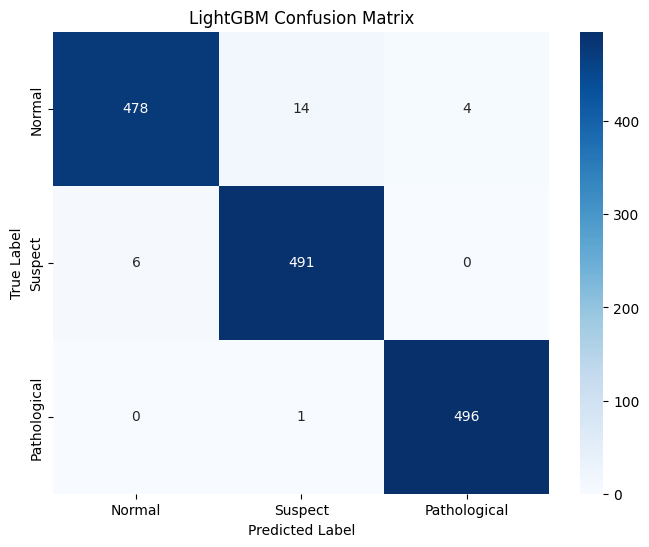

In [60]:
# Initialize the LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    objective='multiclass',
    class_weight='balanced',
    random_state=42
)

# Train the LightGBM model on the resampled and scaled training data
lgb_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_lgb = lgb_classifier.predict(X_test_scaled)

# Evaluate LightGBM performance
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix for LightGBM
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


epoch 0  | loss: 0.78495 | train_accuracy: 0.61381 | valid_accuracy: 0.60738 |  0:00:01s
epoch 1  | loss: 0.47248 | train_accuracy: 0.43424 | valid_accuracy: 0.42617 |  0:00:03s
epoch 2  | loss: 0.3452  | train_accuracy: 0.59453 | valid_accuracy: 0.58121 |  0:00:04s
epoch 3  | loss: 0.35175 | train_accuracy: 0.56432 | valid_accuracy: 0.56107 |  0:00:06s
epoch 4  | loss: 0.3292  | train_accuracy: 0.56547 | valid_accuracy: 0.55772 |  0:00:07s
epoch 5  | loss: 0.29018 | train_accuracy: 0.50964 | valid_accuracy: 0.50134 |  0:00:09s
epoch 6  | loss: 0.28325 | train_accuracy: 0.55741 | valid_accuracy: 0.54094 |  0:00:12s
epoch 7  | loss: 0.254   | train_accuracy: 0.59971 | valid_accuracy: 0.58859 |  0:00:13s
epoch 8  | loss: 0.24113 | train_accuracy: 0.65525 | valid_accuracy: 0.64698 |  0:00:16s
epoch 9  | loss: 0.23    | train_accuracy: 0.68029 | valid_accuracy: 0.67047 |  0:00:18s
epoch 10 | loss: 0.23739 | train_accuracy: 0.62129 | valid_accuracy: 0.60604 |  0:00:20s
epoch 11 | loss: 0.31

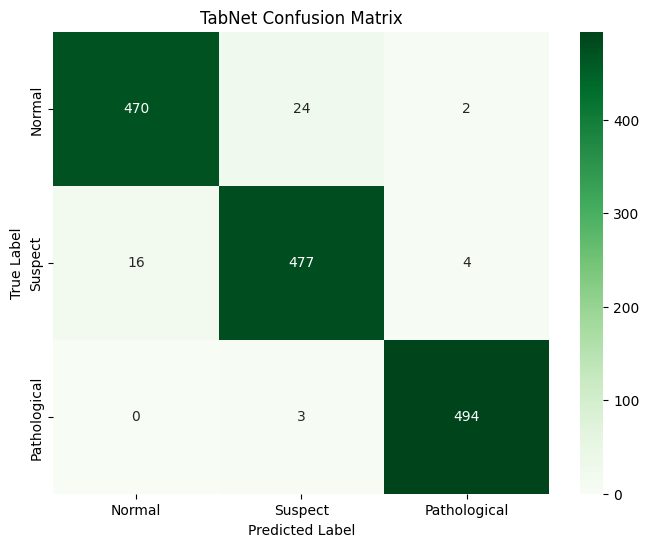

In [61]:
# Initialize the TabNet Classifier
tabnet_classifier = TabNetClassifier(
    n_d=64,                # Dimension of the decision step
    n_a=64,                # Dimension of the attention step
    n_steps=5,             # Number of steps in the architecture
    gamma=1.3,             # Relaxation parameter
    lambda_sparse=1e-3,    # Sparse regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax', # "sparsemax" or "entmax"
    verbose=1
)

# Train the TabNet model on the resampled and scaled training data
tabnet_classifier.fit(
    X_train=X_train_scaled.values,
    y_train=y_train.values,
    eval_set=[(X_train_scaled.values, y_train.values), (X_test_scaled.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)

# Make predictions on the test set
y_pred_tabnet = tabnet_classifier.predict(X_test_scaled.values)

# Evaluate TabNet performance
print("\nTabNet Classification Report:")
print(classification_report(y_test, y_pred_tabnet, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix for TabNet
conf_matrix_tabnet = confusion_matrix(y_test, y_pred_tabnet)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tabnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('TabNet Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [62]:
# Initialize StratifiedKFold
n_folds = 5
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize arrays to hold out-of-fold predictions for training data
oof_preds_lgb = np.zeros((X_train_scaled.shape[0], 3))  # 3 classes
oof_preds_tabnet = np.zeros((X_train_scaled.shape[0], 3))  # 3 classes

# Initialize arrays to hold test set predictions
test_preds_lgb = np.zeros((X_test_scaled.shape[0], 3))
test_preds_tabnet = np.zeros((X_test_scaled.shape[0], 3))

print("Generating out-of-fold predictions...")

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    print(f"Fold {fold + 1}")

    # Split data
    X_tr, X_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # LightGBM
    lgb_fold = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        num_leaves=31,
        objective='multiclass',
        class_weight='balanced',
        random_state=42
    )
    lgb_fold.fit(X_tr, y_tr)
    oof_preds_lgb[valid_idx] = lgb_fold.predict_proba(X_val)
    test_preds_lgb += lgb_fold.predict_proba(X_test_scaled) / n_folds

    # TabNet
    tabnet_fold = TabNetClassifier(
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.3,
        lambda_sparse=1e-3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='sparsemax',
        verbose=0
    )
    tabnet_fold.fit(
        X_train=X_tr.values,
        y_train=y_tr.values,
        eval_set=[(X_val.values, y_val.values)],
        eval_name=['valid'],
        eval_metric=['accuracy'],
        max_epochs=100,
        patience=20,
        batch_size=256,
        virtual_batch_size=128
    )
    oof_preds_tabnet[valid_idx] = tabnet_fold.predict_proba(X_val.values)
    test_preds_tabnet += tabnet_fold.predict_proba(X_test_scaled.values) / n_folds

print("Out-of-fold predictions generated.")


Generating out-of-fold predictions...
Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 2780, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Early stopping occurred at epoch 84 with best_epoch = 64 and best_valid_accuracy = 0.96115
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2498
[LightG


Ensemble Model Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.98       496
     Suspect       0.97      0.99      0.98       497
Pathological       0.99      1.00      0.99       497

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      1490



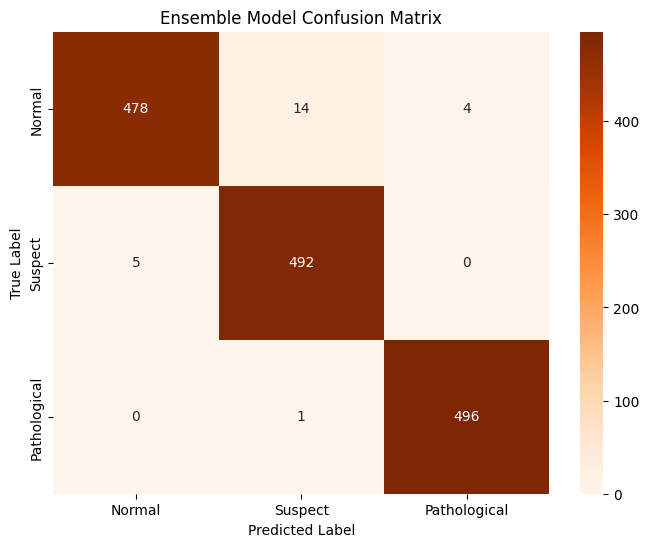

Ensemble Model Accuracy: 0.9839
LightGBM Accuracy: 0.9832
TabNet Accuracy: 0.9671
Ensemble Model Accuracy: 0.9839


In [63]:
# Create meta-features for the training set
meta_X_train = np.hstack((oof_preds_lgb, oof_preds_tabnet))

# Create meta-features for the test set
meta_X_test = np.hstack((test_preds_lgb, test_preds_tabnet))

# Define the meta-learner target
meta_y_train = y_train.values

# Initialize the Logistic Regression meta-learner
meta_learner = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Train the meta-learner on the meta-features
meta_learner.fit(meta_X_train, meta_y_train)

# Make predictions on the test set meta-features
y_pred_ensemble = meta_learner.predict(meta_X_test)

# Evaluate the Ensemble Model
print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix for Ensemble Model
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# Individual Models' Accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
accuracy_tabnet = accuracy_score(y_test, y_pred_tabnet)

print(f"LightGBM Accuracy: {accuracy_lgb:.4f}")
print(f"TabNet Accuracy: {accuracy_tabnet:.4f}")
print(f"Ensemble Model Accuracy: {accuracy:.4f}")



Meta-Learner Coefficients:
              LightGBM_Normal  LightGBM_Suspect  LightGBM_Pathological  \
Normal               2.457584         -1.020521              -1.268880   
Suspect             -0.979864          2.344068              -1.248584   
Pathological        -1.477720         -1.323546               2.517464   

              TabNet_Normal  TabNet_Suspect  TabNet_Pathological  
Normal             1.485042       -0.222906            -1.093953  
Suspect           -0.128838        0.834372            -0.589915  
Pathological      -1.356205       -0.611466             1.683869  


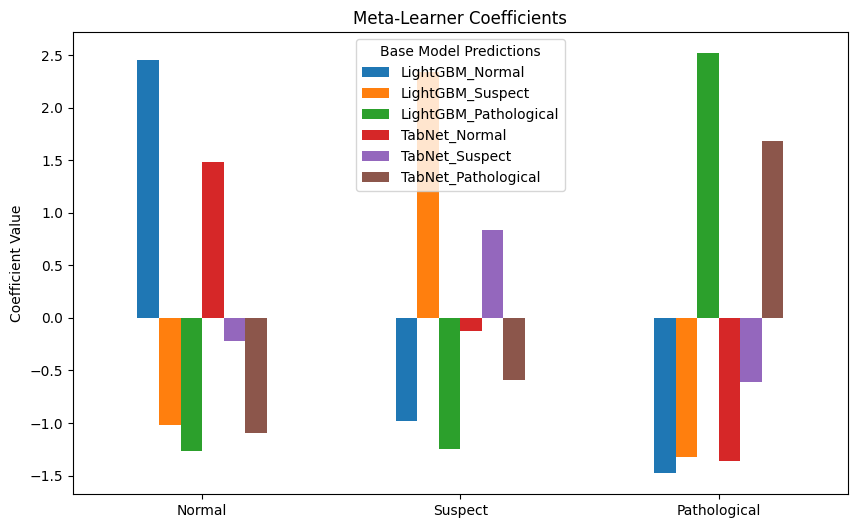

In [64]:
# Coefficients of the meta-learner
meta_coefficients = meta_learner.coef_

# Create a DataFrame to display the coefficients
coeff_df = pd.DataFrame(meta_coefficients, columns=[
    'LightGBM_Normal', 'LightGBM_Suspect', 'LightGBM_Pathological',
    'TabNet_Normal', 'TabNet_Suspect', 'TabNet_Pathological'
], index=['Normal', 'Suspect', 'Pathological'])

print("\nMeta-Learner Coefficients:")
print(coeff_df)

# Plot the coefficients
coeff_df.plot(kind='bar', figsize=(10, 6))
plt.title('Meta-Learner Coefficients')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=0)
plt.legend(title='Base Model Predictions')
plt.show()


In [65]:
# Save the meta-learner
joblib.dump(meta_learner, 'meta_learner.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the LightGBM model
joblib.dump(lgb_classifier, 'lightgbm_model.pkl')

# Save the TabNet model
tabnet_classifier.save_model('tabnet_model.zip')

print("Models have been saved successfully.")


Successfully saved model at tabnet_model.zip.zip
Models have been saved successfully.
